## 평가환경 및 장비

In [1]:
import tensorflow as tf
import numpy as np
from model.load_model import get_trained_model_ckpt, get_trained_model_h5
from utils.load_data import get_datasets, get_datasets_np
from utils.utils import set_seed
import os
import json
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  

print("HW: ")
!nvidia-smi --query-gpu=name --format=csv,noheader
print("\nOS: ")
!cat /etc/*release | grep "DESCRIPTION"
print(f"\nDeep learning library : Tensorflow version {tf.__version__} ")
print("\nMemory : ")
!free -h 

HW: 
NVIDIA GeForce RTX 2080

OS: 
DISTRIB_DESCRIPTION="Ubuntu 20.04.6 LTS"

Deep learning library : Tensorflow version 2.8.0 

Memory : 
              total        used        free      shared  buff/cache   available
Mem:           62Gi       2.1Gi        14Gi       3.0Mi        46Gi        59Gi
Swap:         2.0Gi        73Mi       1.9Gi


## 데이터 및 모델 불러오기

In [2]:
with open("configs/base.json", 'r') as f:
    model_configs = json.load(f)
    
set_seed(0)

origin_model = get_trained_model_h5()
model = get_trained_model_ckpt('logs/tuning_0.1',configs=model_configs,epoch=None)
X,Y, class_weights = get_datasets_np(tuning=True)

idx=6 
X_KU_ICU = X[idx][:, :, :-5]
Y_KU_ICU = Y[idx]

loading pretrained model from ./logs/best_model/lstm_dp04.h5
loading pretrained model from logs/tuning_0.1/checkpoint/run_158
Model: "severity_prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 25)]           0         
                                                                 
 dropout (Dropout)           (None, 6, 25)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 6, 16)            2176      
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 6, 16)             0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 6, 16)            1600      
 nal)                                                

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score

columns = ['Rox', 'MEWS', 'NEWS', 'Sofa', 'MV-EWS(2nd)', 'MV-EWS(3rd)']
y_probs = []
fpr_list = []
tpr_list = []
auc_list = []
precision_list = []
recall_list = []
auprc_list = []

def sigmoid(lst):
    return 1 / (1 + np.exp(-np.array(lst)))

for i in range(len(columns)):
    if i == 0 : # rox index
        y_prob = 1-sigmoid(X[idx][:,-1,-5+i])
    elif i < len(columns)-2:  # 'MEWS', 'NEWS', 'Sofa',
        y_prob = sigmoid(X[idx][:,-1,-5+i])
    elif i == len(columns)-2: # 'MV-EWS(2nd)'
        y_prob = origin_model.predict(X_KU_ICU) # 'MV-EWS(3rd)'
    else:
        y_prob = model.predict(X_KU_ICU)
    
    y_probs.append(y_prob)

    fpr, tpr, _ = roc_curve(Y[idx], y_probs[i])
    pr, rec, _ = precision_recall_curve(Y[idx], y_probs[i])
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(auc(fpr,tpr))
    precision_list.append(pr)
    recall_list.append(rec)
    auprc_list.append(auc(rec,pr))

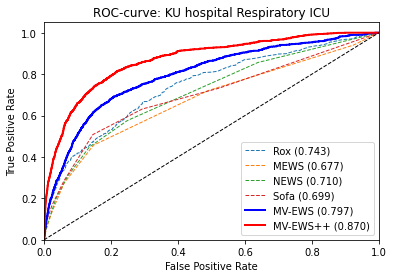

In [14]:
plt.figure()
lw = 2
columns = ['Rox', 'MEWS', 'NEWS', 'Sofa', 'MV-EWS', 'MV-EWS++']
for i in range(len(columns)):
    if i<4:
        plt.plot(
            fpr_list[i],
            tpr_list[i],
            lw=lw/2,
            linestyle='dashed',
            label=columns[i] + " (%0.3f)" %  round(auc_list[i], 3)
        )    
    elif i==4:
        plt.plot(
            fpr_list[i],
            tpr_list[i],
            lw=lw,
            color='blue', 
            label=columns[i] + " (%0.3f)" %  round(auc_list[i], 3)
        )
    elif i==5:
        plt.plot(
            fpr_list[i],
            tpr_list[i],
            lw=lw,
            color='red', 
            label=columns[i] + " (%0.3f)" %  round(auc_list[i], 3)
        )

    
plt.plot([0, 1], [0, 1], color="black", lw=lw/2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-curve: KU hospital Respiratory ICU")
plt.legend(loc="lower right")
plt.show()

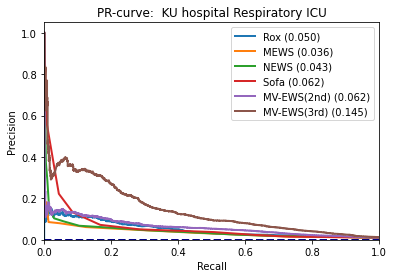

In [5]:
plt.figure()
lw = 2

for i in range(len(columns)):
    plt.plot(
        recall_list[i],
        precision_list[i],
        lw=lw,
        label=columns[i] + " (%0.3f)" %  round(auprc_list[i], 3)
    )
plt.plot([0, 1], [0, 0], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR-curve:  KU hospital Respiratory ICU")
plt.legend(loc="upper right")
plt.show()

In [6]:
from sklearn.metrics import accuracy_score

print("Predict severity of patients using MV-EWS Model...\n")

prob = model.predict(X_KU_ICU,verbose=True)
pred= np.where(prob>0.5,1,0)
acc = accuracy_score(Y_KU_ICU, pred)

print(f"\n3차년도 MV-EWS 모델 중증도 예측 정확도: {acc*100:.4f}")


Predict severity of patients using MV-EWS Model...

3231/3231 [==============================] - 7s 2ms/step

3차년도 MV-EWS 모델 중증도 예측 정확도: 93.1265
